In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "1234",
                            database = "ecommerce")

cur = db.cursor()

 1. List all unique cities where customers are located.

In [3]:
cur.execute("select distinct customer_city from customers")
data = cur.fetchall()
df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


2. Count the number of orders placed in 2017.

In [11]:
cur.execute("select count(order_id) from orders where year(order_purchase_timestamp) = 2017")
data = cur.fetchall()
"total number of placed in 2017", data [0][0] ## [0][0] value tuple ke array ma na batave tena mate


('total number of placed in 2017', 135303)

 3. Find the total sales per category.

In [47]:
cur.execute("""select upper(products.product_category) as category, 
	   round(sum(payments.payment_value),2) as sales
       from products
       join order_items
       on products.product_id = order_items.product_id
	   join payments
       on payments.order_id = order_items.order_id
       group by category""")

data = cur.fetchall()
#import pandas as pd
df = pd.DataFrame(data, columns = ["category", "sales"])
#df.to_csv('desktop/customer_cities.csv', index=False)
df.head()


,category,sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33


4. Calculate the percentage of orders that were paid in installments.

In [8]:
cur.execute("""select (sum(case when payment_installments >= 1 then 1 else 0 end))/count(*)*100  from payments""")
data = cur.fetchall()
"the percentage of orders that were paid in installments",data [0][0]

('the percentage of orders that were paid in installments', Decimal('99.9981'))

5. Count the number of customers from each state. 

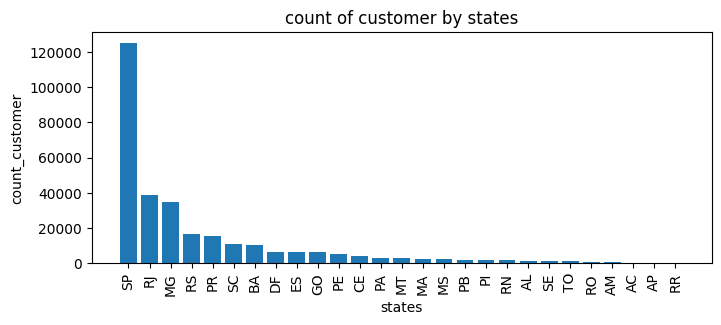

In [4]:
query = ("""SELECT customer_state AS state, COUNT(customer_id) AS total FROM customers GROUP BY customer_state""")
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["state", "customer_count"])
df = df.sort_values(by = "customer_count", ascending = False) #DESCENDING ORDER ME GRPH KARNE KE LIYE
plt.figure(figsize = (8,3)) #graph ki size manage karne ke liye
plt.bar(df["state"],df["customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("count_customer")
plt.title("count of customer by states")

#sns.barplot(data = df,x = "state", y = "customer_count" , palette = "spring")
plt.show()  

6. Calculate the number of orders per month in 2018.

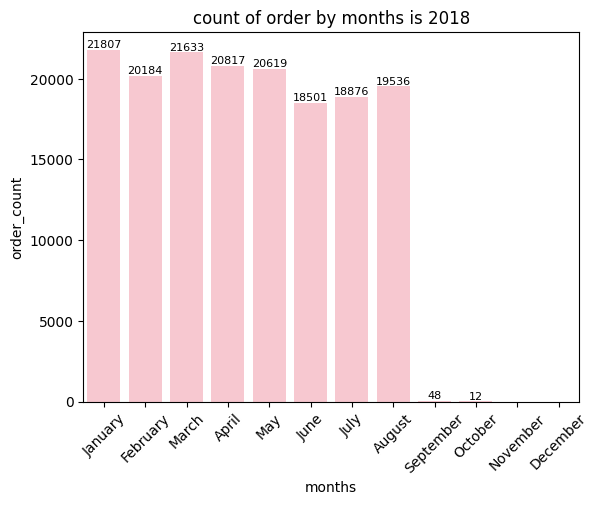

In [71]:
cur.execute("""select monthname(order_purchase_timestamp) as months, count(order_id) from orders
where year(order_purchase_timestamp) = 2018
group by months""")
data = cur.fetchall()
o = ["January","February","March","April","May","June","July","August","September","October","November","December"]
df = pd.DataFrame(data, columns = ["months","order_count"])
ax = sns.barplot(data = df, x = "months",y = "order_count",order = o, color = "pink")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0],fontsize=8) #plot ke upr label ke liye
plt.title("count of order by months is 2018")
plt.show()

7. Find the average number of products per order, grouped by customer city.

In [9]:
cur.execute("""WITH count_per_order AS (SELECT orders.order_id, orders.customer_id, count(order_items.order_id) AS oc
FROM orders
JOIN order_items
ON orders.order_id = order_items.order_id
GROUP BY orders.order_id, orders.customer_id)

SELECT customers.customer_city, ROUND(AVG(count_per_order.oc),2) AS average_orders
FROM customers
JOIN count_per_order
ON customers.customer_id = count_per_order.customer_id
GROUP BY customers.customer_city order by average_orders desc""")

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["customer city", "average order"])
df.head(10)

,customer city,average order
0,padre carvalho,21.00
1,celso ramos,19.50
2,datas,18.00
3,candido godoi,18.00
4,matias olimpio,15.00
5,cidelandia,12.00
6,curralinho,12.00
7,picarra,12.00
8,morro de sao paulo,12.00
9,teixeira soares,12.00


8. Calculate the percentage of total revenue contributed by each product category.

In [7]:
cur.execute("""select upper(products.product_category) as category, 
	   round((sum(payments.payment_value)/(select sum(payment_value)from payments))*100,2) as sales_percentage
       from products
       join order_items
       on products.product_id = order_items.product_id
	   join payments
       on payments.order_id = order_items.order_id
       group by category order by sales_percentage desc""")

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["category", "prouuct average disstribution"])
df
#plt.pie(df["prouuct average disstribution"], labels = df["category"])
#plt.show()

,category,prouuct average disstribution
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
...,...,...
69,HOUSE COMFORT 2,0.01
70,CDS MUSIC DVDS,0.01
71,PC GAMER,0.01
72,FASHION CHILDREN'S CLOTHING,0.00


9. Identify the correlation between product price and the number of times a product has been purchased.

In [12]:
cur.execute("""SELECT products.product_category, COUNT(order_items.product_id), ROUND(AVG(order_items.price),2)
FROM products
join order_items
ON products.product_id = order_items.product_id
GROUP BY products.product_category""")

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["category", "count", "price"])
#df

arr1 = df["count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("the correlation between product price and the number of times a product has been purchased is", a[0][1])


the correlation between product price and the number of times a product has been purchased is -0.10631514167157562


10. Calculate the total revenue generated by each seller, and rank them by revenue.

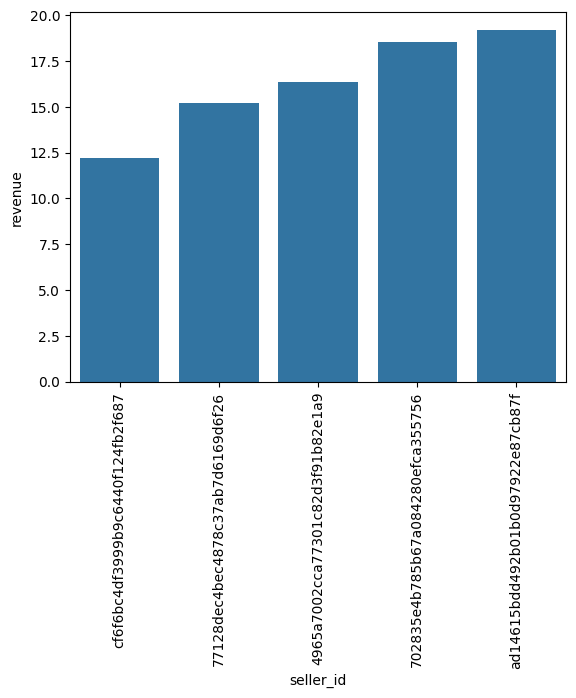

In [5]:
cur.execute("""select *, dense_rank() over(order by revenue) AS rn from 
(SELECT order_items.seller_id, ROUND(SUM(payments.payment_value),2) AS revenue
FROM order_items
JOIN payments
ON order_items.order_id = payments.order_id
GROUP BY order_items.seller_id) as A """)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()
sns.barplot(data = df, x = "seller_id", y = "revenue")

plt.xticks(rotation = 90)
plt.show()